## Transfer Learning with tensorflow part:1 Feature Extraction

### Downloading data

In [ ]:
 # Getting data (10% of 10 food classes from food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-05 07:42:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.119.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   222MB/s    in 0.7s    

2022-02-05 07:42:19 (222 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Walk through data
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

There are 2 directories and 0 images in '10_food_classes_10_percent'. 
There are 10 directories and 0 images in '10_food_classes_10_percent/test'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'. 
There are 0 directories and 250 images in '10_food_classes

### Create data laoders (prepare the data)
we'll use the `ImageDataGenerator` class to load in our images in batches

In [ ]:
# Setup inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen= ImageDataGenerator(rescale=1/255.)
test_datagen= ImageDataGenerator(rescale=1/255.)

print("training images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMG_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")


training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks are:

* Tracking experiments with `TensorBoard callback`
* Model checkpoint with the `ModelCheckpoint callback`
* Stopping a model from training (before it trains too long and overfits) with the `EarlyStopping callbacks`

In [ ]:
# Create a TensorBoard callback (functionized because we need to create a new one for each)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%M%d-%H%M%S")
  tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log file to: {log_dir}")
  return tensorboard_callback

### Creating model using TensorFlow Hub

In the past we'have used TensorFlow to create our models layer by layer

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models
resenet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() funtion to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
      model_url(str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in the output layer, 
          should be equal to number of target classes, default 10.
  
  Returns: 
  An Uncompiled Keras Sequential model with model_url as feature extractor
  layer and Dense output layer with num_classes output neurons.
  
  """
  # Download the pretrained model and save it as Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
     feature_extractor_layer,
     layers.Dense(num_classes, activation="softmax", name="output_layer")                          
  ])
  return model

In [ ]:
# Create Resnet Model
resnet_model = create_model(resenet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data_10_percent,
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")])

Saving TensorBoard log file to: tensorflow_hub/resnet50V2/20224205-074232
Epoch 1/5
24/24 [==============================] - 42s 1s/step - loss: 2.1745 - accuracy: 0.3253 - val_loss: 1.2799 - val_accuracy: 0.6036
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.0075 - accuracy: 0.6787 - val_loss: 0.8787 - val_accuracy: 0.7224
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6710 - accuracy: 0.8067 - val_loss: 0.7676 - val_accuracy: 0.7508
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.5019 - accuracy: 0.8627 - val_loss: 0.6953 - val_accuracy: 0.7728
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.4022 - accuracy: 0.8987 - val_loss: 0.6699 - val_accuracy: 0.7768


In [ ]:
# Plot loss curve function
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss =history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

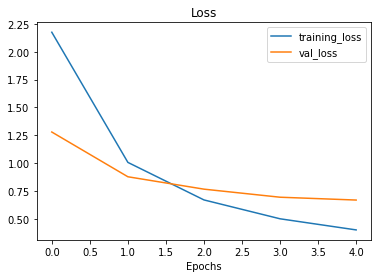

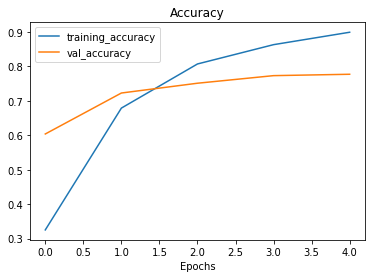

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Create EFFICIENTNET model

In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log file to: tensorflow_hub/efficientnetB0/20224505-074522
Epoch 1/5
24/24 [==============================] - 33s 947ms/step - loss: 1.8790 - accuracy: 0.4040 - val_loss: 1.3162 - val_accuracy: 0.7200
Epoch 2/5
24/24 [==============================] - 20s 838ms/step - loss: 1.0665 - accuracy: 0.7680 - val_loss: 0.8669 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 19s 835ms/step - loss: 0.7571 - accuracy: 0.8293 - val_loss: 0.6945 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 19s 833ms/step - loss: 0.6092 - accuracy: 0.8587 - val_loss: 0.6111 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 19s 832ms/step - loss: 0.5145 - accuracy: 0.8947 - val_loss: 0.5536 - val_accuracy: 0.8672


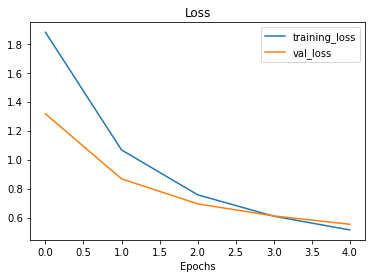

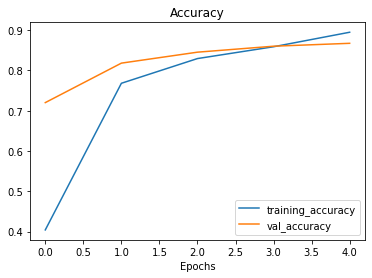

In [ ]:
plot_loss_curves(efficientnet_history)

 ### Comparing our models using TensorBoard

** What is TensorBoard**

A way to visualize

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "efficientNetB0 vs. resNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=o5rT1N8E9OvsB5MrO5IAyXr7mbpmIZ&prompt=consent&access_type=off

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/9gRNwi2wQimEaQgpYfNwGA/
	Name                 efficientNetB0 vs. resNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   9gRNwi2wQimEaQgpYfNwGA
	Created              2022-02-05 08:01:46 (3 minutes ago)
	Updated              2022-02-05 08:01:48 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5795363
Total: 1 experiment(s)


In [ ]:
# delete tensorboard experiment
# !tensorboard dev delete --experiment_id 9gRNwi2wQimEaQgpYfNwGA